Graphs to make:
- [V] 1. Conversion in function of SEI
- [ ] 2. Product yield in function of conversion with selectivity as slope
- [V] 3. Atom balances in function of SEI
- [ ] 4. Product yield in function of SEI

Step 0: Importing libraries and creating static variables

In [1]:
# Importing the libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as stats

import warnings
from numpy import RankWarning

# Suppress RankWarnings
warnings.filterwarnings('ignore', category=RankWarning)

In [2]:
# Define the alpha value for the post-plasma materials
alpha = 0.75

# Define the color for each material
packing_colors = {
    'SiO₂ Type S': (0/255, 0/255, 0/255),
    'SiO₂@TiO₂  3 h': (86/255, 180/255, 233/255),
    'SiO₂@TiO₂  6 h': (0/255, 114/255, 178/255),
    'SiO₂@TiO₂  9 h': (230/255, 159/255, 0/255),
    'SiO₂@TiO₂ 12 h': (213/255, 94/255, 0/255)
}

# determine order of materials for plotting
packing_order = [
    'SiO₂ Type S',
    'SiO₂@TiO₂  3 h',
    'SiO₂@TiO₂  6 h',
    'SiO₂@TiO₂  9 h',
    'SiO₂@TiO₂ 12 h',      
]

t_quantile = stats.t.ppf(1 - 0.05/2, 7)

In [3]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# Set font size
plt.rcParams['font.size'] = 7

Step 1: Importing & preparing data

In [4]:
# Importing the dataset
# set the folder and file name
folder_path = r'N:\FWET\FDCH\AdsCatal\General\personal_work_folders\plasmacatdesign\co2-splitting\uhasselt'
file_path = os.path.join(folder_path, 'uhasselt_co2_splitting_reaction_data_combined.csv')

# read the Excel file
df = pd.read_csv(file_path)

In [5]:
# Preparing the data for all plots
df = df[
    df['res_time_sec'] <= 80
].assign(
    compound=lambda x: x['compound'].map(
        {
            'CO2': 'CO₂',
            'CO': 'CO',
            'O2': 'O₂',
            'N2': 'N₂'
        }
    ),
    packing=lambda x: x['packing'].map(
        {
            'SiO2@Anatase TiO2 - 220/03H': 'SiO₂@TiO₂  3 h',
            'SiO2@Anatase TiO2 - 220/06H': 'SiO₂@TiO₂  6 h',
            'SiO2@Anatase TiO2 - 220/09H': 'SiO₂@TiO₂  9 h',
            'SiO2@Anatase TiO2 - 220/12H': 'SiO₂@TiO₂ 12 h',
            'SiO2 Type S 1.6-1.8 mm': 'SiO₂ Type S'
        }
    )
).query(
    'packing in ["SiO₂ Type S", "SiO₂@TiO₂  3 h", "SiO₂@TiO₂  6 h", "SiO₂@TiO₂  9 h", "SiO₂@TiO₂ 12 h"]'
).reset_index(
    drop=True
).copy()

Step 2: Conv vs SEI

In [6]:
# Prepare the data for the conversion plotting
df_conv = df[
    [
        'packing',
        'compound',
        'res_time_sec',
        'conv',
        'conv_sd'
    ]
].query(
    "compound in ['CO₂']"
).drop_duplicates(
).assign(
    conv=lambda x: x['conv'] * 100,
    conv_sd=lambda x: x['conv_sd'] * 100,
    sei_ideal_kjmol=lambda x: round(
        number=30/((1-0.4774)*(17.31/x['res_time_sec']))*24.055,
        ndigits=-1
    ).astype(int)
).groupby(
    ['packing', 'res_time_sec', 'sei_ideal_kjmol']
).agg(
    conv_mean=('conv', 'mean'),
    conv_sd=('conv_sd', lambda x: ((x**2).sum()**0.5)/len(x))
).reset_index(
).copy()

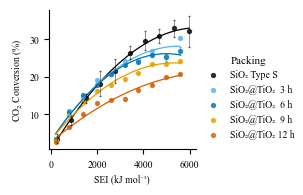

In [7]:
# Plot the conversion vs SEI
g = sns.lmplot(
    data=df_conv,
    x='sei_ideal_kjmol',
    y='conv_mean',
    hue='packing',
    palette=packing_colors,
    hue_order=packing_order,
    height=5/2.54,
    aspect=1.1,
    order=2,
    ci=None,
    legend=True,
    scatter_kws={'s': 8, 'alpha': alpha},
    line_kws={'lw': 0.9}
).set(
    xlabel='SEI (kJ mol⁻¹)',
    ylabel='CO$_2$ Conversion (%)'
)

g.legend.set_title('Packing', prop={'size': 8})

ax = g.axes.flatten()[0]

for packing in df_conv['packing'].unique():
    subset = df_conv[df_conv['packing'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['conv_mean'],
        yerr=subset['conv_sd'] * t_quantile,
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_conv_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 3: Atom balances

In [8]:
# Prepare the data
df_balance = df[
    [
        'packing',
        'compound',
        'res_time_sec',
        'balance_c',
        'balance_c_sd',
        'balance_o',
        'balance_o_sd'
    ]
].query(
    "compound in ['CO₂']"
).drop_duplicates(
).assign(
    balance_c=lambda x: x['balance_c'] * 100,
    balance_c_sd=lambda x: x['balance_c_sd'] * 100,
    balance_o=lambda x: x['balance_o'] * 100,
    balance_o_sd=lambda x: x['balance_o_sd'] * 100,
    sei_ideal_kjmol=lambda x: round(
        number=30/((1-0.4774)*(17.31/x['res_time_sec']))*24.055,
        ndigits=-1
    ).astype(int)
).groupby(
    ['packing', 'res_time_sec', 'sei_ideal_kjmol']
).agg(
    balance_c=('balance_c', 'mean'),
    balance_c_sd=('balance_c_sd', lambda x: ((x**2).sum()**0.5)/len(x)),
    balance_o=('balance_o', 'mean'),
    balance_o_sd=('balance_o_sd', lambda x: ((x**2).sum()**0.5)/len(x))
).reset_index(
).copy()

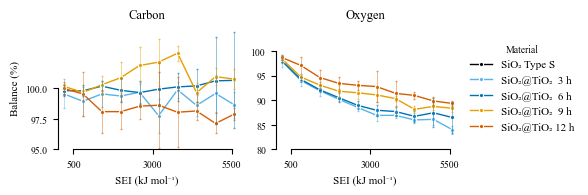

In [9]:
# Create the figure
fig = plt.figure(figsize=(15/2.54, 5/2.54), )

# Create the gridspec
gs = gridspec.GridSpec(1, 2, figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Plot on first subplot
sns.lineplot(
    data=df_balance,
    x="sei_ideal_kjmol",
    y="balance_c",
    hue="packing",
    palette=packing_colors,
    ax=ax1,
    legend=False,
    marker='o',
    markersize=3,
    linewidth=1
)

# Plot on second subplot
sns.lineplot(
    data=df_balance,
    x="sei_ideal_kjmol",
    y="balance_o",
    hue="packing",
    palette=packing_colors,
    ax=ax2,
    legend=True,
    marker='o',
    markersize=3,
    linewidth=1
)

#place legend outside top right corner of plot
ax2.legend(
    bbox_to_anchor=(1.03, 0.5),
    loc='center left',
    frameon=False,
    fontsize=8,
    title="Material"
)

# Iterate over the axes to add error bars
# Iterate over the axes and materials to add error bars
for ax, balance in zip(fig.axes, ['balance_c', 'balance_o']):
    for packing in df_balance['packing'].unique():
        subset = df_balance[(df_balance['packing'] == packing)]
        ax.errorbar(
            subset['sei_ideal_kjmol'], 
            subset[balance], 
            yerr=subset[balance+'_sd'] * t_quantile, 
            fmt='none',
            ecolor=packing_colors[packing],
            elinewidth=0.5, 
            capsize=1,
            alpha=0.6
        )
        
# Set titles
ax1.set_title("Carbon", fontsize=9)
ax2.set_title("Oxygen", fontsize=9)

# Set y label
ax1.set_ylabel("Balance (%)", fontsize=8)
ax2.set_ylabel("")

# Set x label
ax1.set_xlabel("SEI (kJ mol⁻¹)", fontsize=8)
ax2.set_xlabel("SEI (kJ mol⁻¹)", fontsize=8)

# Set y limits and ticks
ax1.set_ylim(95, 105)
ax1.spines['left'].set_bounds(95, 100)
ax1.set_yticks(ticks=[95, 97.5, 100])

ax2.set_ylim(80, 105)
ax2.spines['left'].set_bounds(80, 100)
ax2.set_yticks(ticks=[80, 85, 90, 95, 100])

# Set x limits and ticks
ax1.spines['bottom'].set_bounds(500, 5500)
ax2.spines['bottom'].set_bounds(500, 5500)
ax1.set_xlim(0, 5650)
ax2.set_xlim(0, 5650)
ax1.set_xticks(ticks=[500, 3000, 5500])
ax2.set_xticks(ticks=[500, 3000, 5500])

sns.despine(ax=ax1, left=False, bottom=False)
sns.despine(ax=ax2, left=False, bottom=False)

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_balance_vs_sei.pdf"
)
plt.show()

In [10]:
# Close all figures
plt.close('all')

# Clear all variables
%reset -f